#`This notebook is an Illustration to create a Sentiment Analyzer with Universal Sentence Encoder Using Tensorflow💻`

For more information, check out [USE](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder). 

<img src="https://www.gstatic.com/devrel-devsite/prod/vbf66214f2f7feed2e5d8db155bab9ace53c57c494418a1473b23972413e0f3ac/tensorflow/images/lockup.svg" width="300"
         height="120"> 

## Setup
Install the required packages and setup the imports:  

In [ ]:
!nvidia-smi

Tue Jul 28 17:51:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!pip install tensorflow_text==2.0.1

In [ ]:
!pip install wordcloud 

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='ticks', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 

In [ ]:
tf.test.is_gpu_available() 

True

## Dataset Exploration
We'll load the Hotel reviews dataset which I have uploaded in my google drive.

In [ ]:
!gdown --id 1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r --output 515k-hotel-reviews-data-in-europe.zip 

Downloading...
From: https://drive.google.com/uc?id=1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r
To: /content/515k-hotel-reviews-data-in-europe.zip
47.3MB [00:01, 35.9MB/s]


In [ ]:
!unzip -q 515k-hotel-reviews-data-in-europe.zip

In [ ]:
df = pd.read_csv("Hotel_Reviews.csv", parse_dates=['Review_Date'])
df.shape 

(515738, 17)

In [ ]:
df.head() 

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## Exploratory data analysis

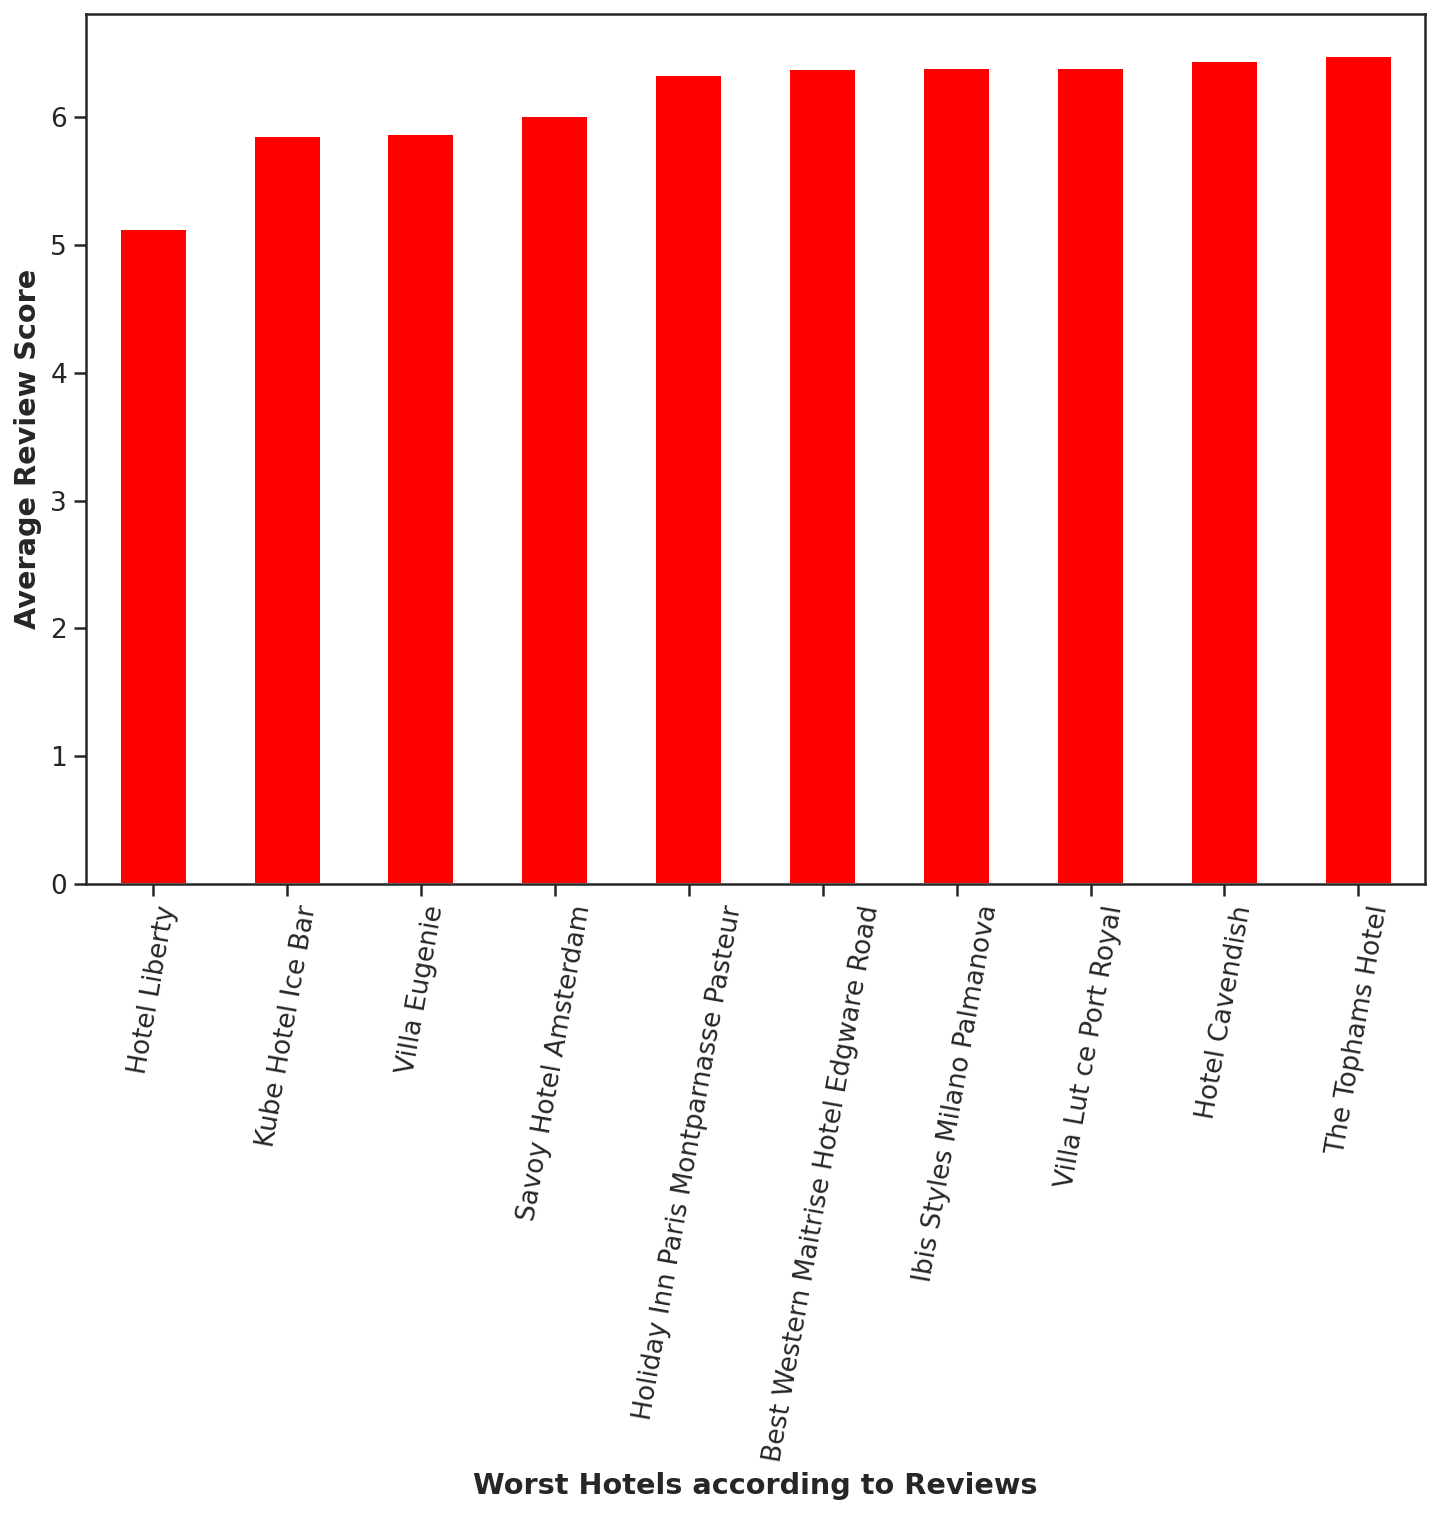

In [ ]:
#Worst Hotels
worst_hotels =df.groupby('Hotel_Name')['Reviewer_Score'].mean().sort_values(ascending=True).head(10)
worst_hotels.plot(kind="bar",color="Red")
plt.xlabel('Worst Hotels according to Reviews', fontweight="bold")
plt.xticks(rotation=80)
plt.ylabel('Average Review Score', fontweight="bold")
plt.show()  

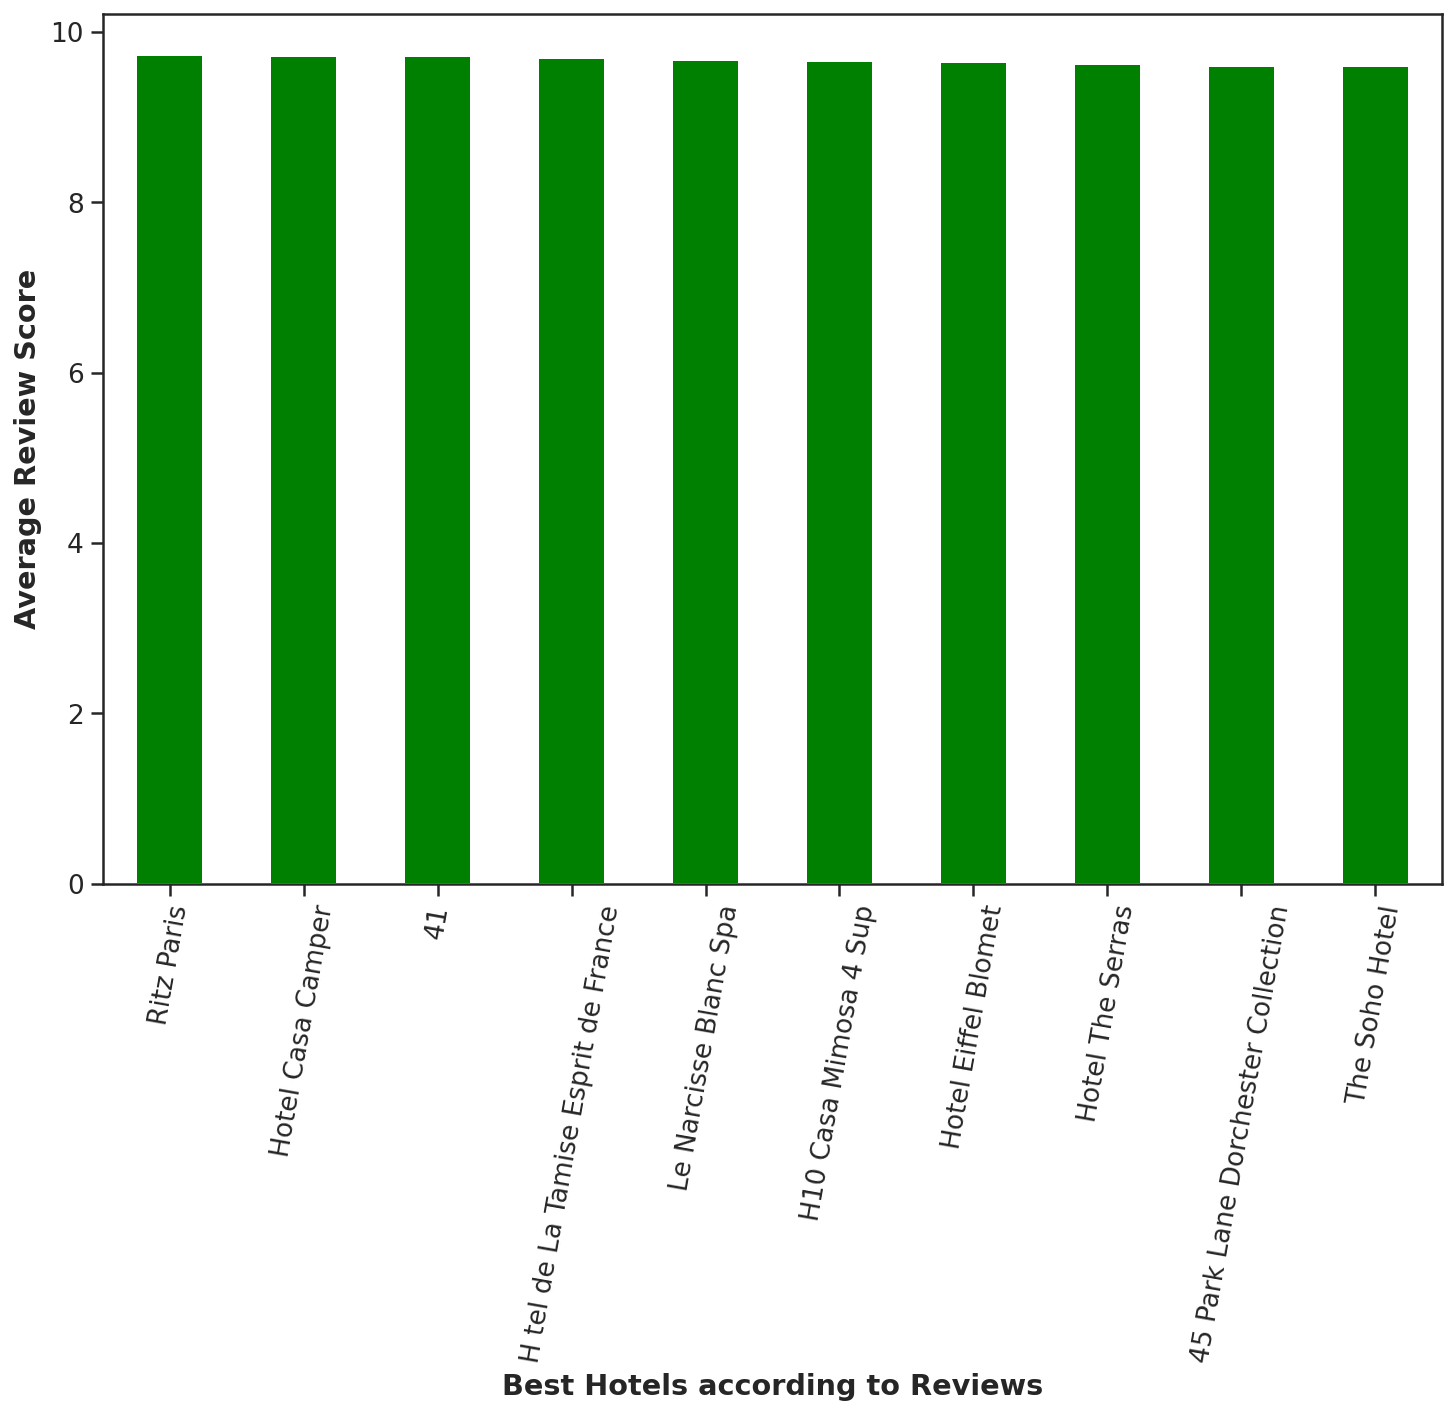

In [ ]:
#Best Hotels
best_hotels = df.groupby('Hotel_Name')['Reviewer_Score'].mean().sort_values(ascending=False).head(10)
best_hotels.plot(kind="bar",color = "Green")
plt.xlabel('Best Hotels according to Reviews', fontweight="bold")
plt.xticks(rotation=80)
plt.ylabel('Average Review Score', fontweight="bold") 
plt.show() 

In [ ]:
df['Tags'].unique() 

array(["[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']",
       "[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 4 nights ']",
       "[' Leisure trip ', ' Family with young children ', ' Duplex Double Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
       ...,
       "[' Leisure trip ', ' Solo traveler ', ' Superior Double Room with Garden View ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       "[' Business trip ', ' Solo traveler ', ' Superior Double Room with Garden View ', ' Stayed 2 nights ']",
       "[' Leisure trip ', ' Family with young children ', ' Standard Double or Twin Room ', ' Stayed 10 nights ']"],
      dtype=object)

In [ ]:
#Mining some important information from tags
df['Leisure'] = df['Tags'].map(lambda x: 1 if ' Leisure trip ' in x else 0)
df['Business'] = df['Tags'].map(lambda x: 2 if ' Business trip ' in x else 0)
df['Trip_type'] = df['Leisure'] + df['Business'] 

In [ ]:
import random
df['Trip_type'] = df[df['Trip_type'] == 0]['Trip_type'].map(lambda x: 1 if random.random() > 0.2 else 2)
df['Trip_type'] = df['Trip_type'].fillna(0)
df['Trip_type'] = df['Trip_type'] + df['Business'] + df['Leisure']
del df['Leisure'] , df['Business'] 

In [ ]:
df['Trip_type'].value_counts()

1.0    429838
2.0     85900
Name: Trip_type, dtype: int64

In [ ]:
#Couple or Solo or Group or Family_with_older children or Family with younger Children
df['Solo'] = df['Tags'].map(lambda x: 1 if ' Solo traveler ' in x else 0)
df['Couple'] = df['Tags'].map(lambda x: 2 if ' Couple ' in x else 0)
df['Group'] = df['Tags'].map(lambda x: 3 if ' Group ' in x else 0)
df['Family_with_young_children'] = df['Tags'].map(lambda x: 4 if ' Family with young children ' in x else 0)
df['Family_with_older_children'] = df['Tags'].map(lambda x: 5 if ' Family with older children ' in x else 0)
df['whom'] = df['Solo'] + df['Couple'] + df['Group'] + df['Family_with_young_children'] + df['Family_with_older_children']
del df['Solo'], df['Couple'],df['Group'], df['Family_with_young_children'],df['Family_with_older_children']  

In [ ]:
df.whom.value_counts() 

2    252294
1    108545
3     65392
4     61015
5     26349
0      2143
Name: whom, dtype: int64

In [ ]:
#I will assign 0's to 2 because it is the least.
df['whom'] = df['whom'].map(lambda x: 2 if x == 0 else x)
df.whom.value_counts() 

2    254437
1    108545
3     65392
4     61015
5     26349
Name: whom, dtype: int64

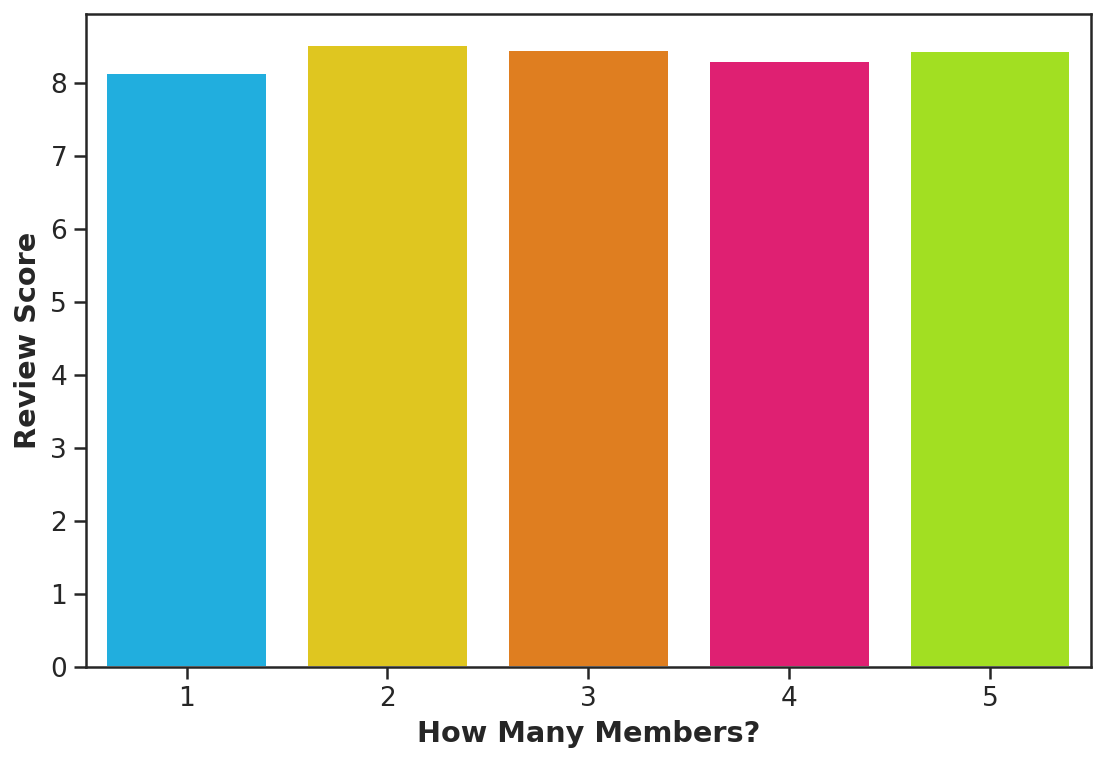

In [ ]:
#Whom
whom_hist=df.groupby("whom")['Reviewer_Score'].mean().reset_index().sort_values(by='whom',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='whom',y='Reviewer_Score', data=whom_hist) 
plt.xlabel('How Many Members?', fontweight="bold")
plt.ylabel('Review Score', fontweight="bold");

## Some Preprocessing
We have loaded the 512K Hotel Review Dataset, Let's do some preprocessing!

In [ ]:
df['review'] = df['Negative_Review'] + df['Positive_Review']

We merged Negative and Positive reviews to one Review Column

In [ ]:
df.head() 

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Trip_type,whom,review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,1.0,2,I am so angry that i made this post available...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,1.0,2,No Negative No real complaints the hotel was g...
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,1.0,4,Rooms are nice but for elderly a bit difficul...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,1.0,1,My room was dirty and I was afraid to walk ba...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,1.0,2,You When I booked with your company on line y...


Considering the review score less than 7 as bad and greater than 7 as good.

In [ ]:
df['review_type'] = df['Reviewer_Score'].apply( lambda x: 'bad' if x<7 else 'good') 

`Our final dataFrame`

In [ ]:
df = df[['review', 'review_type']] 

In [ ]:
df.head() 

,review,review_type
0,I am so angry that i made this post available...,bad
1,No Negative No real complaints the hotel was g...,good
2,Rooms are nice but for elderly a bit difficul...,good
3,My room was dirty and I was afraid to walk ba...,bad
4,You When I booked with your company on line y...,bad


In [ ]:
df['review_type'].value_counts() 

good    428887
bad      86851
Name: review_type, dtype: int64

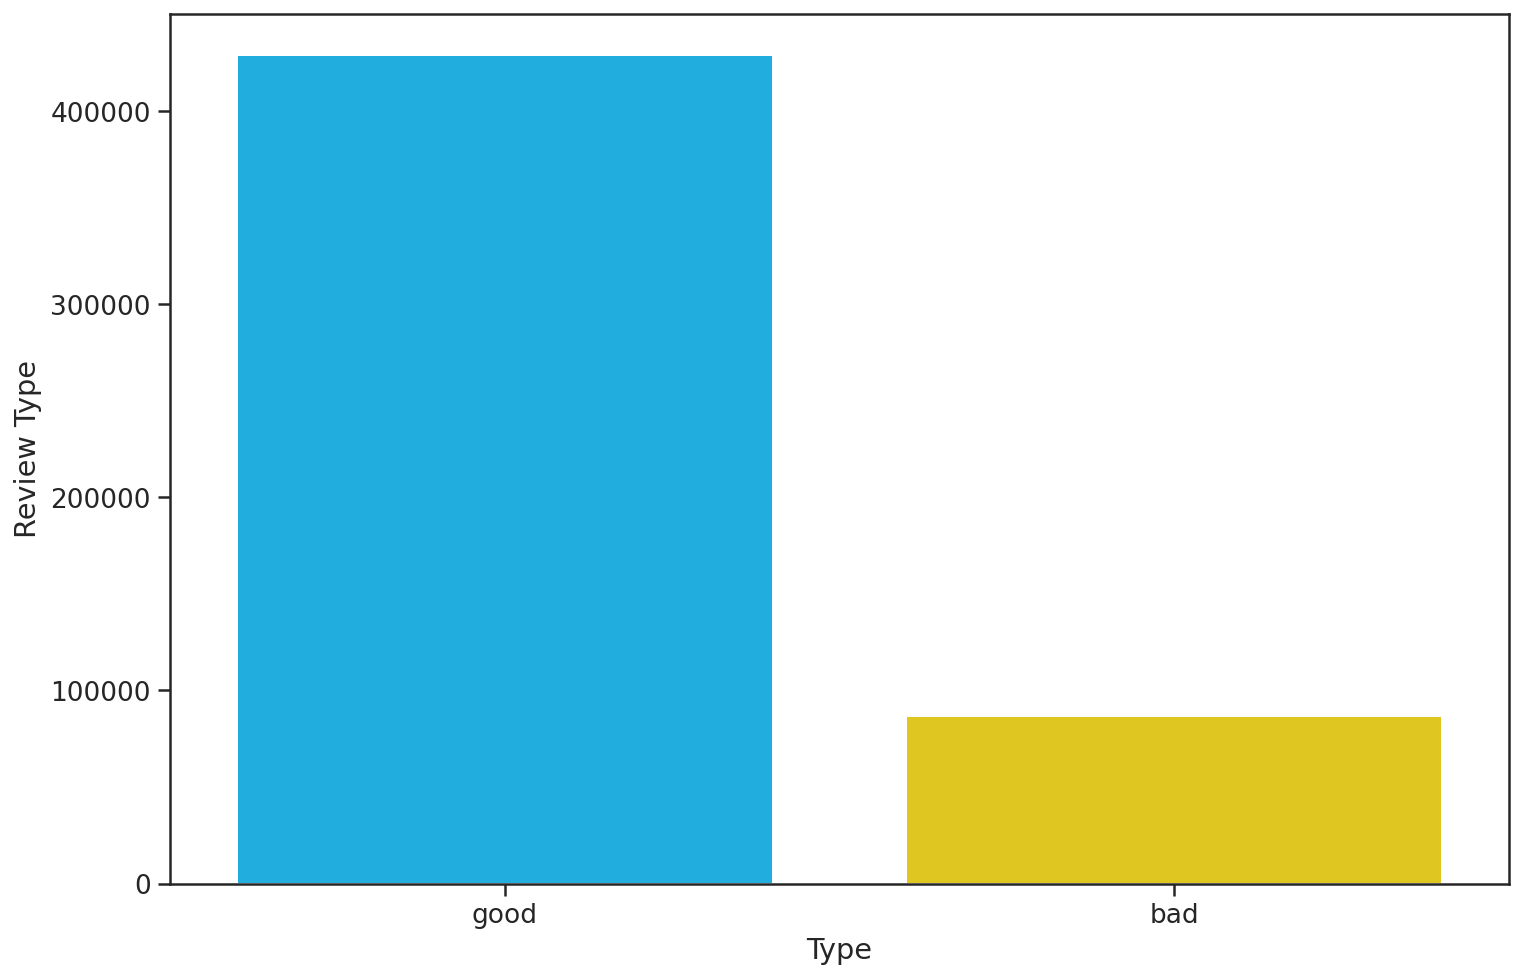

In [ ]:
sns.countplot(x='review_type', data = df, order= df['review_type'].value_counts().index)
plt.xlabel('Type');
plt.ylabel('Review Type') ;

That's hugely imbalanced, but it's okay. We're going to convert the dataset into good and bad balanced dataframe.

In [ ]:
good_reviews = df[df.review_type == "good"]
bad_reviews = df[df.review_type == "bad"] 

In [ ]:
print(good_reviews.shape, bad_reviews.shape) 

(428887, 2) (86851, 2)


Let's do an interesting WordCloud Visualization, This will tell us which Word in a particular Review Type is most commonly used.

In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text) 

Let's write a helper function to show the Word Cloud.

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title, fontweight="bold")
  plt.axis("off")
  plt.show();

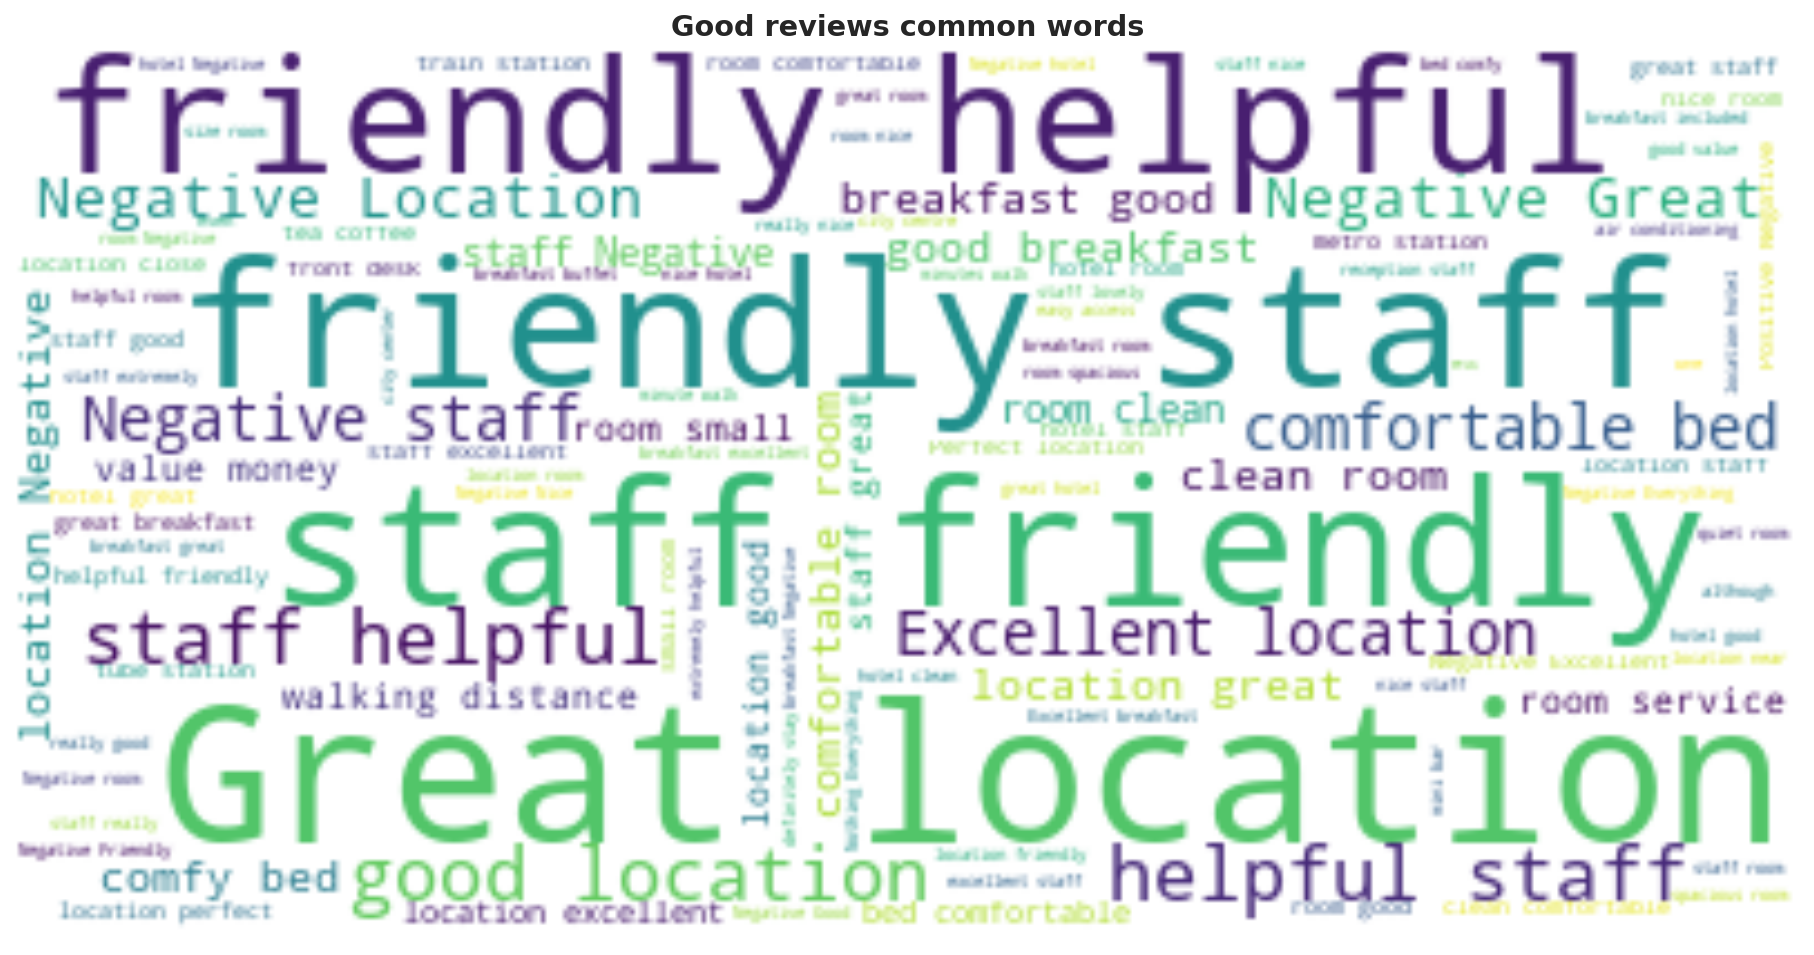

In [ ]:
show_word_cloud(good_reviews_cloud, "Good reviews common words") 

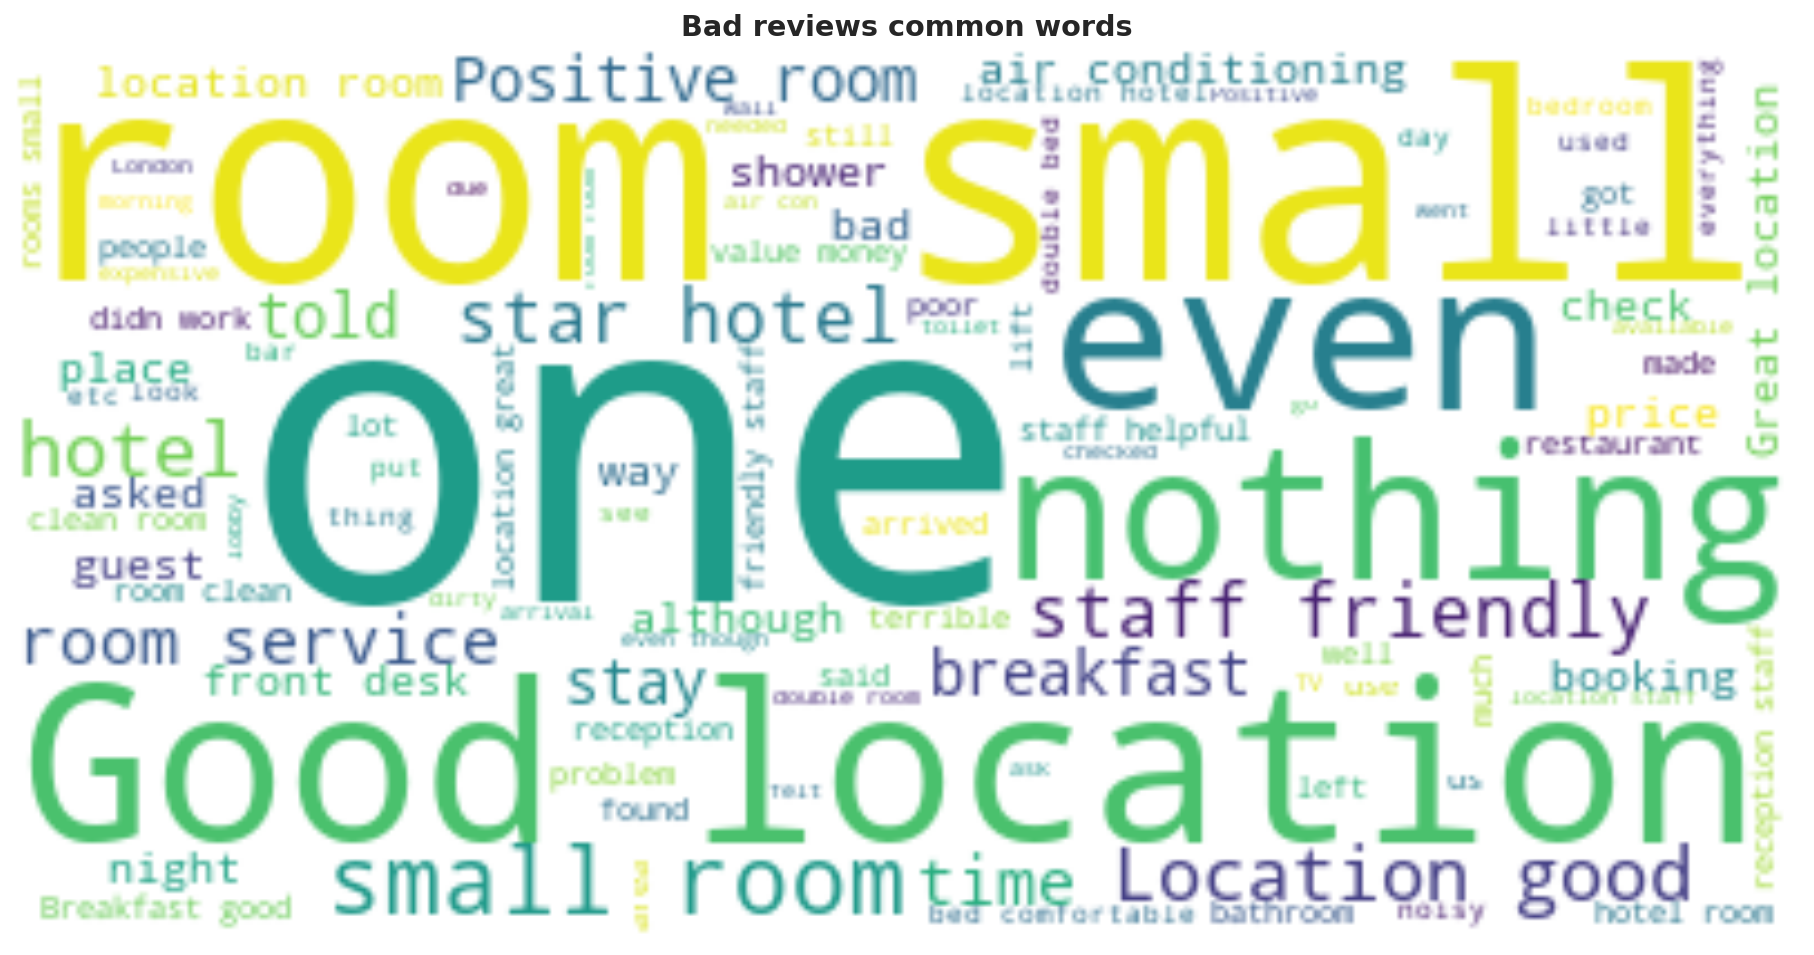

In [ ]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words") 

Let's Balance our dataset by taking same number of examples of Bad Reviews into Good Reviews.

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)
bad_df = bad_reviews 

In [ ]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape 

(173702, 2)

Woohoo! Our final Dataframe is now ready to be trained.

In [ ]:
review_df.head() 

,review,review_type
0,Nothing not to like Location was excellent r...,good
1,Replenishment of supplies in room toiletries ...,good
2,No Negative The views,good
3,Could do with biscuits and a complimentary wa...,good
4,Bar prices expensive and mini bar very expens...,good


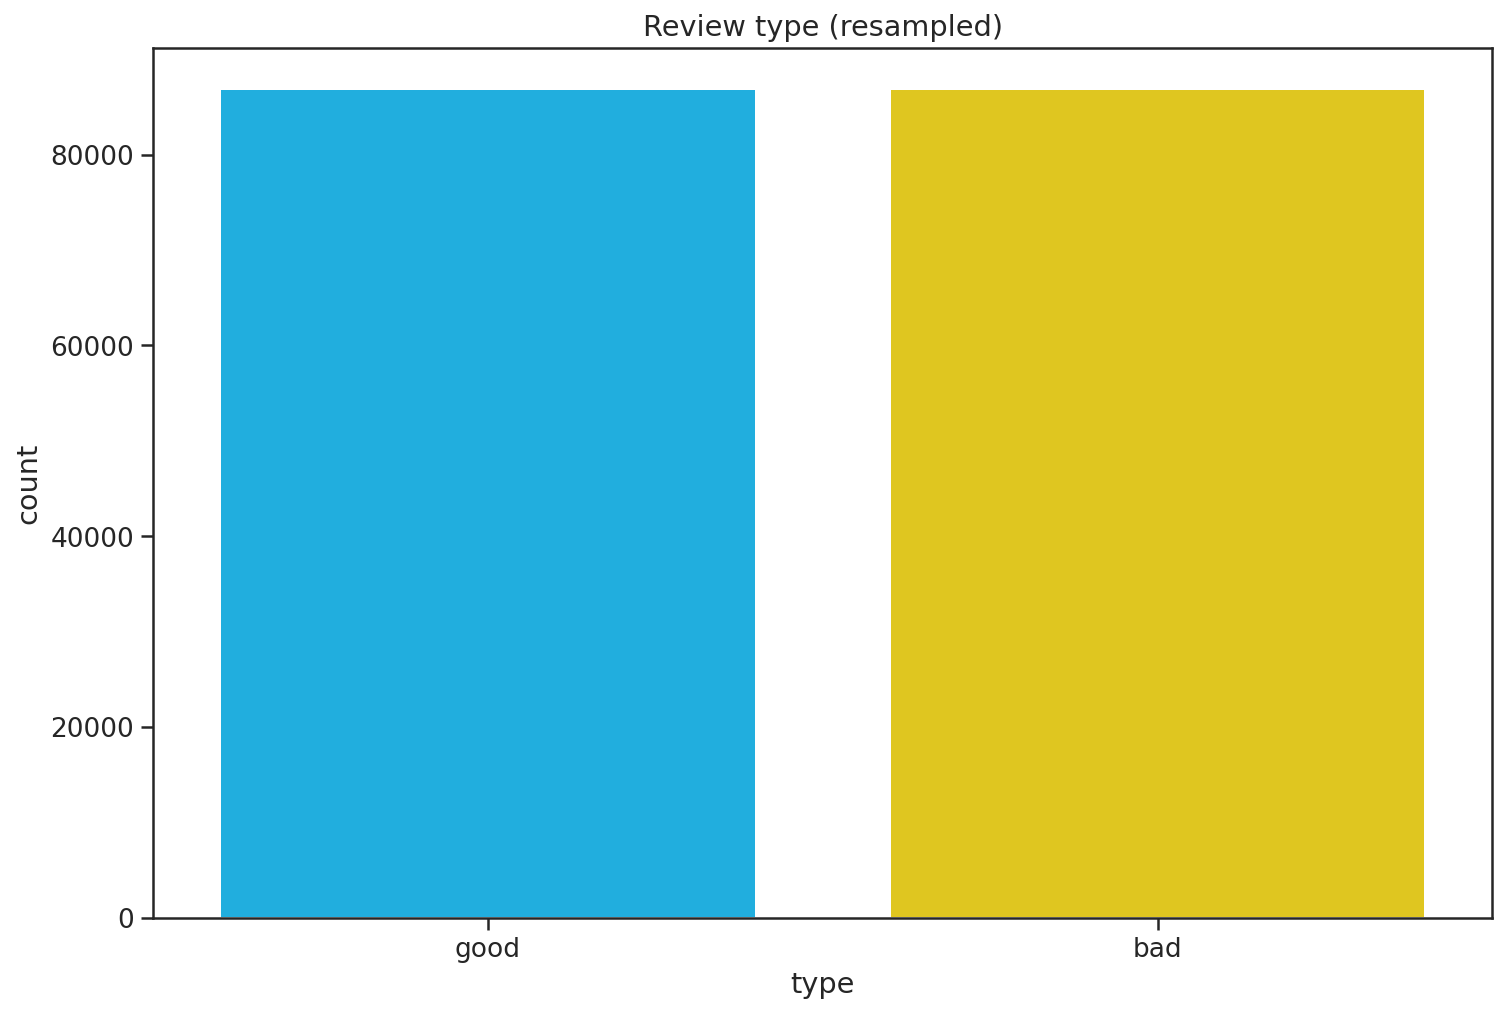

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

## Universal Sentence Encoder

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3") 

Let's take an example and see how USE works.

In [ ]:
sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb_1 = use(sent_1)
emb_2 = use(sent_2) 

In [ ]:
print(emb_1)

tf.Tensor(
[[ 4.34926786e-02 -2.84900889e-02 -1.32353036e-02 -9.69933439e-03
   7.10538626e-02  1.55969174e-03 -3.78732127e-03 -1.32802380e-02
   3.79240401e-02  3.21806185e-02  2.34254468e-02 -5.69685036e-03
   2.95785558e-03  3.05909775e-02  1.83466217e-03 -7.49616027e-02
   9.39225703e-02  5.69443852e-02  1.54223414e-02  3.35284253e-03
  -4.66687325e-03  5.83964139e-02 -2.30502579e-02  1.42986486e-02
  -6.31635031e-03 -2.82636862e-02 -1.02643119e-02 -2.60976516e-02
  -2.85463370e-02 -4.02124114e-02 -4.14567813e-02  5.50362468e-02
  -3.64354812e-02 -8.20011497e-02  3.27202305e-02 -7.77934864e-02
  -5.73716359e-04 -1.01796689e-03 -1.84015818e-02  2.54646949e-02
   2.06639860e-02 -1.58619676e-02 -5.77327460e-02  1.64963882e-02
  -5.81914447e-02 -4.91563343e-02 -2.17538849e-02  3.22028585e-02
  -3.50887254e-02  3.29053663e-02  7.58625120e-02 -3.62930773e-03
   5.70798665e-02 -3.16381007e-02  2.77980417e-02 -4.98413555e-02
   7.90734142e-02 -3.10150590e-02  3.23870853e-02  8.96650553e-02

Our Universal Sentence Encoder is doing all the heavy lifting for us.
It creates a 512 dimension Word Embedding which can be fed into a Model for Learning.

In [ ]:
emb_1.shape 

TensorShape([1, 512])

 Inner dot product between 2 vectors gives the Similarity between two vectors.

In [ ]:
np.inner(emb_1, emb_2).flatten()[0]

0.7925468

Let's convert our Labels, in this case the review type, into one hot vectors.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df['review_type'].to_numpy().reshape(-1, 1)
) 

In [ ]:
type_one_hot.shape

(173702, 2)

Let's split our dataset into Training and Validation.

In [ ]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(review_df['review'], type_one_hot, test_size=.1, random_state=RANDOM_SEED) 

In [ ]:
train_reviews.shape

(156331,)

In [ ]:
test_reviews.shape

(17371,)

In [ ]:
y_train.shape

(156331, 2)

In [ ]:
y_test.shape

(17371, 2)

X_train contains all our Word Embeddings of the Review column (90% of it) in our DataFrame.`(For Training)`

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train) 

100%|██████████| 156331/156331 [35:05<00:00, 74.26it/s]


X_test contains all our Word Embeddings of the Review column (10% of it) in our DataFrame.`(For Testing and Evaluating)`

In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test) 

100%|██████████| 17371/17371 [03:46<00:00, 76.81it/s]


In [ ]:
print(X_train.shape, X_test.shape) 

(156331, 512) (17371, 512)


These are the vectors we are going to work with for our Model.

In [ ]:
print(X_train.shape, y_train.shape)

(156331, 512) (156331, 2)


## Model Architecture

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy']) 

In [ ]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


This is a quite simple Model but still gives great result, you can go crazy and try fine tuning the model for more accuracy. But I'm going to stick to this one :)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1, shuffle=True)

Train on 140697 samples, validate on 15634 samples
Epoch 1/10
140697/140697 [==============================] - 29s 209us/sample - loss: 0.4343 - accuracy: 0.7968 - val_loss: 0.4030 - val_accuracy: 0.8151
Epoch 2/10
140697/140697 [==============================] - 28s 197us/sample - loss: 0.4136 - accuracy: 0.8096 - val_loss: 0.3963 - val_accuracy: 0.8157
Epoch 3/10
140697/140697 [==============================] - 28s 197us/sample - loss: 0.4047 - accuracy: 0.8148 - val_loss: 0.3934 - val_accuracy: 0.8178
Epoch 4/10
140697/140697 [==============================] - 28s 197us/sample - loss: 0.3984 - accuracy: 0.8179 - val_loss: 0.3909 - val_accuracy: 0.8194
Epoch 5/10
140697/140697 [==============================] - 28s 198us/sample - loss: 0.3920 - accuracy: 0.8232 - val_loss: 0.3929 - val_accuracy: 0.8172
Epoch 6/10
140697/140697 [==============================] - 28s 198us/sample - loss: 0.3881 - accuracy: 0.8254 - val_loss: 0.3967 - val_accuracy: 0.8188
Epoch 7/10
140697/140697 [=====

Let's see the Training and Validation Loss Graph.

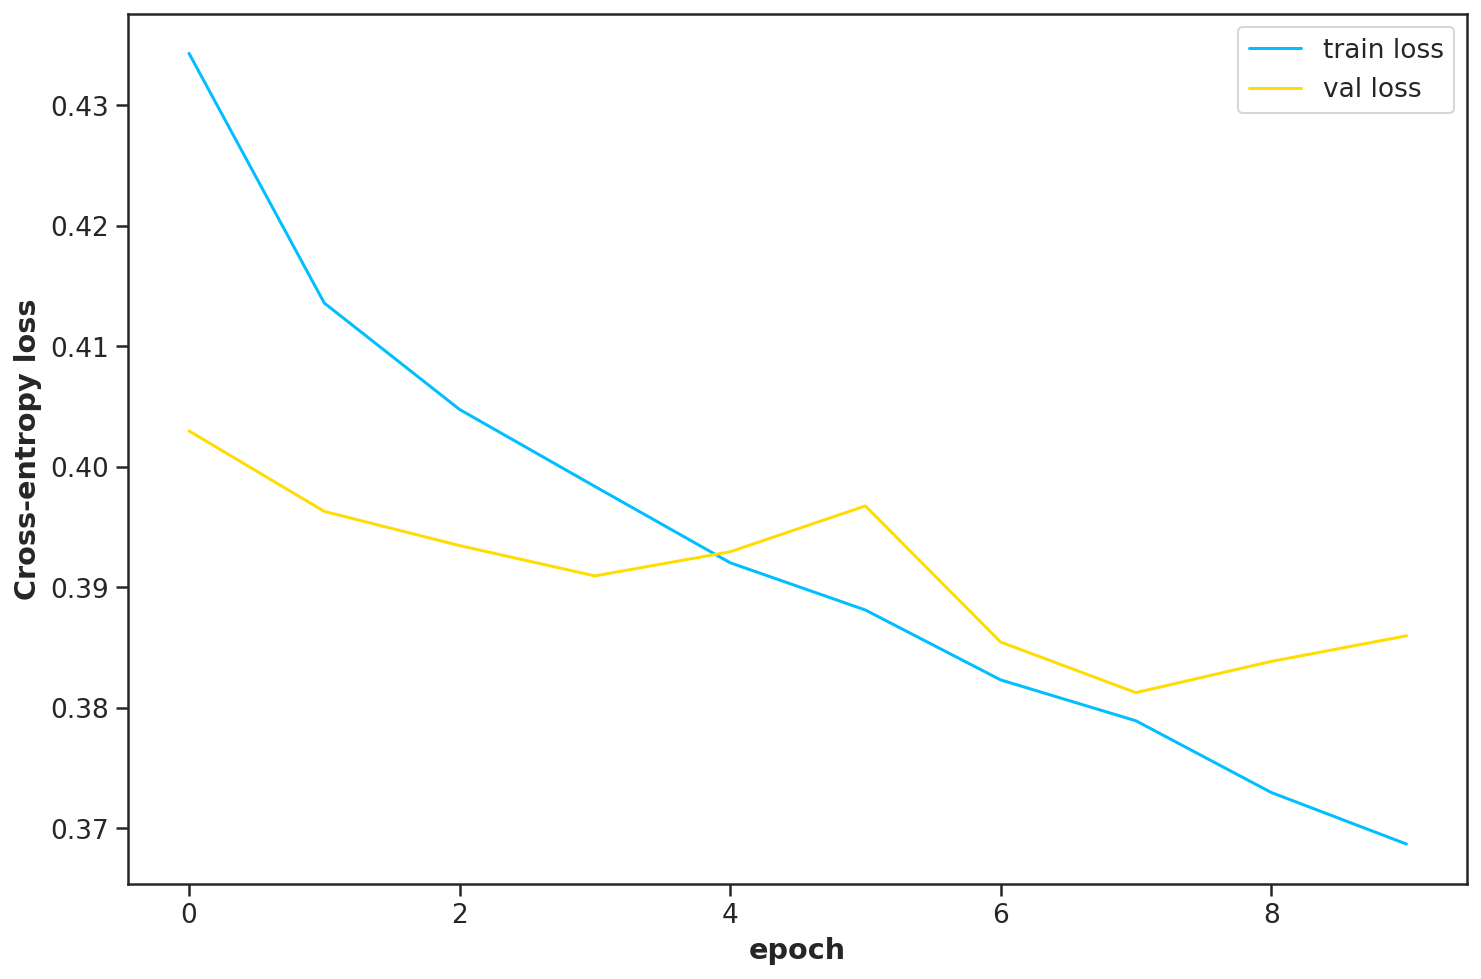

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch", fontweight = 'bold') 
plt.ylabel("Cross-entropy loss", fontweight = 'bold')
plt.legend(); 

Let's see the Training and Validation Accuracy Graph.

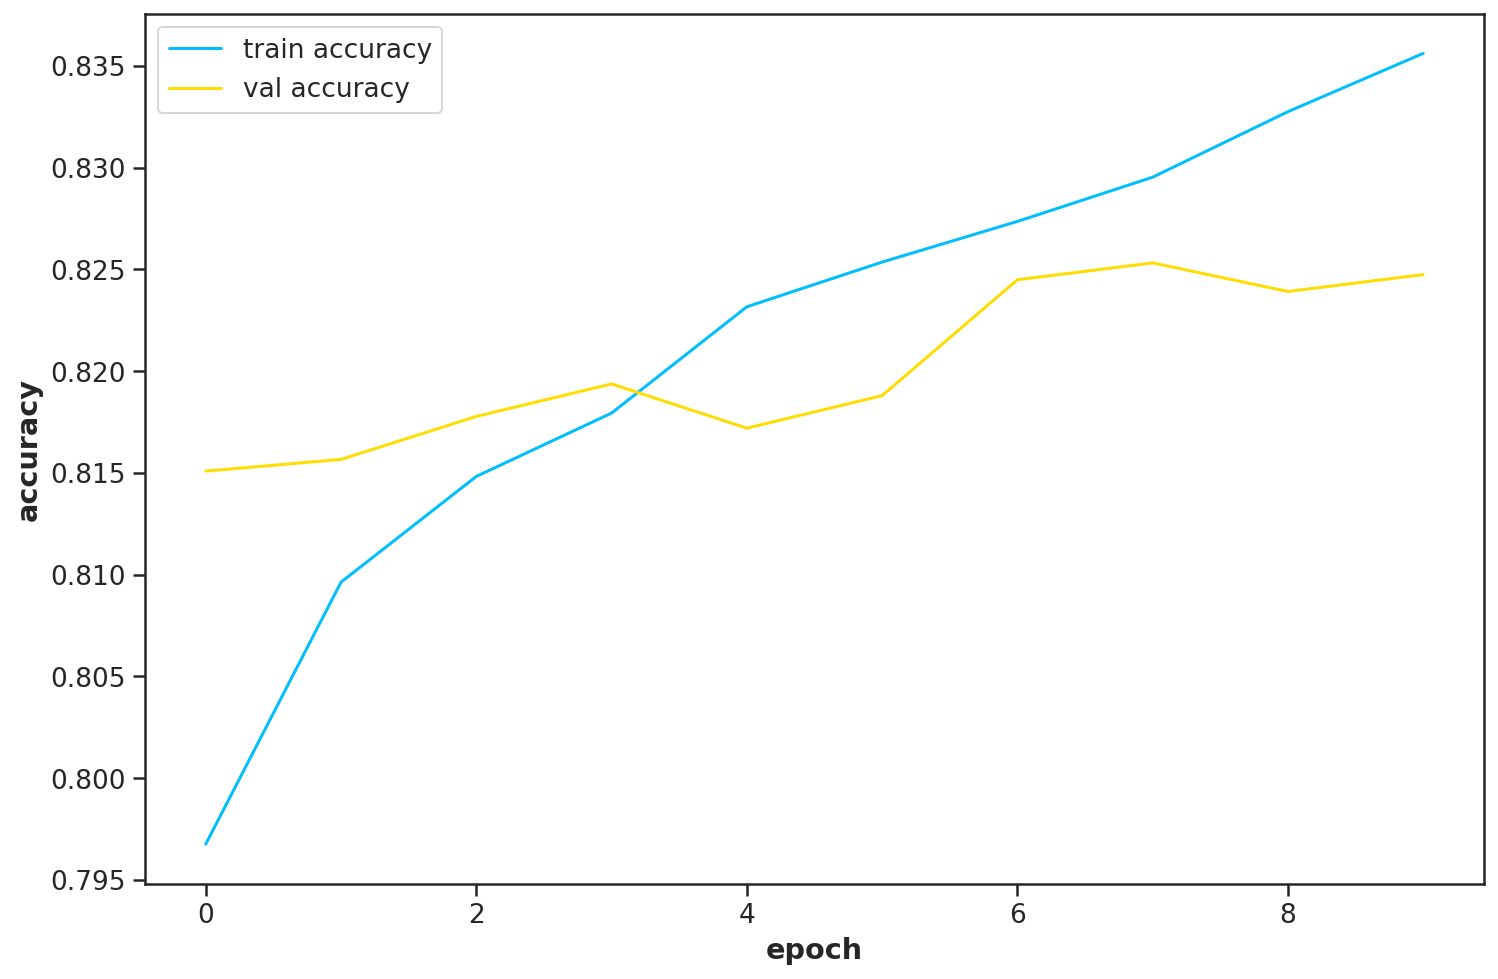

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch", fontweight = 'bold' )
plt.ylabel("accuracy",fontweight = 'bold')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test);

## Predictions

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good") 

 Asked for late checkout and didnt get an answer then got a yes but had to pay 25 euros by noon they called to say sorry you have to leave in 1h knowing that i had a sick dog and an appointment next to the hotel  Location staff 
Bad


In [ ]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good" 

[[0.930021   0.06997904]]


'Bad'

In [ ]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good") 

 Don t really like modern hotels Had no character Bed was too hard  Good location rooftop pool new hotel nice balcony nice breakfast 
Good


In [ ]:
y_pred = model.predict(X_test[1:2])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good" 

[[0.42151976 0.57848024]]


'Good'

## Summary

You now have learned to:

* How to do some Exploratory Data Anaylsis on a Dataset
* Preprocessing Text data for Tensorflow using Universal Sentence Encoder
* Build a simple Neural Network For Sentiment Analysis
* Evaluate the model on test data
* Predict the Sentiment 

## References

* [Tensorflow](https://www.tensorflow.org/api_docs/python/)
* [universal Sentence Encoder](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder)
* [USE Paper](https://arxiv.org/abs/1803.11175)
* [Seaborn](https://seaborn.pydata.org/)